In [1]:
%matplotlib inline
%run 'bin/notebook_utils.py'

/Users/mturilli/Virtualenvs/RP-PAPER-IPDPS18/lib/python2.7/site-packages/radical/utils/atfork/stdlib_fixer.py:63: UserWarning: logging module already imported before fixup.
  warnings.warn('logging module already imported before fixup.')


In [2]:
# Load wrangled data saved in .csv files for both synapse, microbenchmarks and gromacs.
sws_sessions = pd.read_csv('data/synapse/weak_scaling/sessions.csv', index_col=0)
sws_pilots = pd.read_csv('data/synapse/weak_scaling/pilots.csv', index_col=0)
sws_units = pd.read_csv('data/synapse/weak_scaling/units.csv', index_col=0)

In [3]:
print 'Synapse: Total number of successful runs: %s' % sws_sessions.shape[0]
print 'Synapse: Total number of pilots: %s' % sws_pilots.shape[0]
print 'Synapse: Total number of units: %s\n' % sws_units.shape[0]

Synapse: Total number of successful runs: 8
Synapse: Total number of pilots: 8
Synapse: Total number of units: 2976



# Synapse

## Weak Scaling (exp1)

Definitions: 
* Weak scalability: how the solution time varies with the number of processors for a fixed problem size per processor
* Ideal Runtime: the time taken by the workload to run on the given resources without any overhead
* Walltime: the walltime asked for the pilot
* Max Walltime: the maximum walltime that can be asked for the given size of the pilot

|N runs| N tasks | N core/task | N generations | N pilot | N core/pilot | Ideal Runtime  | Walltime | Max Walltime | Resource |
|------|---------|-------------|---------------|---------|--------------|----------------|----------|--------------|----------|
| 2    | 32      | 32          | 1             | 1       | 1024         | 15m            | 1h       | 1h           | Titan    |
| 2    | 64      | 32          | 1             | 1       | 2048         | 15m            | 1h       | 6h           | Titan    |
| 2    | 128     | 32          | 1             | 1       | 4096         | 15m            | 1h       | 6h           | Titan    |
| 2    | 256     | 32          | 1             | 1       | 8192         | 15m            | 1h       | 12h          | Titan    |
| 2    | 512     | 32          | 1             | 1       | 16384        | 15m            | 1h       | 12h          | Titan    |
| 2    | 1024    | 32          | 1             | 1       | 32768        | 15m            | 1h       | 12h          | Titan    |
| 2    | 2048    | 32          | 1             | 1       | 65536        | 15m            | 1h       | 24h          | Titan    |
| 2    | 4096    | 32          | 1             | 1       | 131072       | 15m            | 1h       | 24h          | Titan    |
| 2    | 8192    | 32          | 1             | 1       | 262144       | 15m            | 1h       | 24h          | Titan    |

In [4]:
sws_scaling = sws_sessions[sws_sessions.experiment == 'exp1'][
    ['nunit','TTC','P_LRMS_QUEUING','U_AGENT_QUEUING','U_AGENT_SCHEDULING','U_AGENT_QUEUING_EXEC','U_AGENT_EXECUTING']
        ].groupby(['nunit']).aggregate(
                {'TTC'                 : ['mean','std'],
                 'P_LRMS_QUEUING'      : ['mean','std'],
                 'U_AGENT_QUEUING'     : ['mean','std'],
                 'U_AGENT_SCHEDULING'  : ['mean','std'],
                 'U_AGENT_QUEUING_EXEC': ['mean','std'],
                 'U_AGENT_EXECUTING'   : ['mean','std']})

sws_scaling.rename_axis({'P_LRMS_QUEUING'      :'TTQ'}, axis='columns', inplace=True)
sws_scaling.rename_axis({'U_AGENT_QUEUING'     :'Agent queueing'}, axis='columns', inplace=True)
sws_scaling.rename_axis({'U_AGENT_SCHEDULING'  :'Agent scheduling'}, axis='columns', inplace=True)
sws_scaling.rename_axis({'U_AGENT_QUEUING_EXEC':'Agent queueing execution'}, axis='columns', inplace=True)
sws_scaling.rename_axis({'U_AGENT_EXECUTING'   :'TTX'}, axis='columns', inplace=True)
sws_scaling.rename(index={i: '%s/%s' % (i, i*32) for i in sws_scaling.index.get_values()}, inplace=True)
sws_scaling

TTQ              Agent queueing           Agent queueing execution                   TTX                     TTC              Agent scheduling          
                   mean          std           mean       std                     mean       std        mean        std         mean          std             mean       std
nunit                                                                                                                                                                       
32/1024        55.12050          NaN         0.3245       NaN                 0.567600       NaN   900.18080        NaN   1053.47060          NaN         0.283300       NaN
64/2048       953.82985  1258.176663         0.8294  0.044406                 1.159400  0.015132   940.12655   0.003606   2075.82835  1376.075263         0.722000  0.029698
128/4096     1482.34230  1361.416162         1.9336  0.060953                 2.976900  0.231082   922.77575   3.545363   2514.00745  1364.736523         1.739001  0.057415
256/8192    15661.68065   215.067447         5.3720  0.008910                14.347450  2.186444   978.65000  17.178594  16827.76960    89.619138         4.955049  0.012231
2048/65536  50731.14370          NaN       244.7829       NaN               367.383901       NaN  1402.77530        NaN  52401.49030          NaN       228.591103       NaN

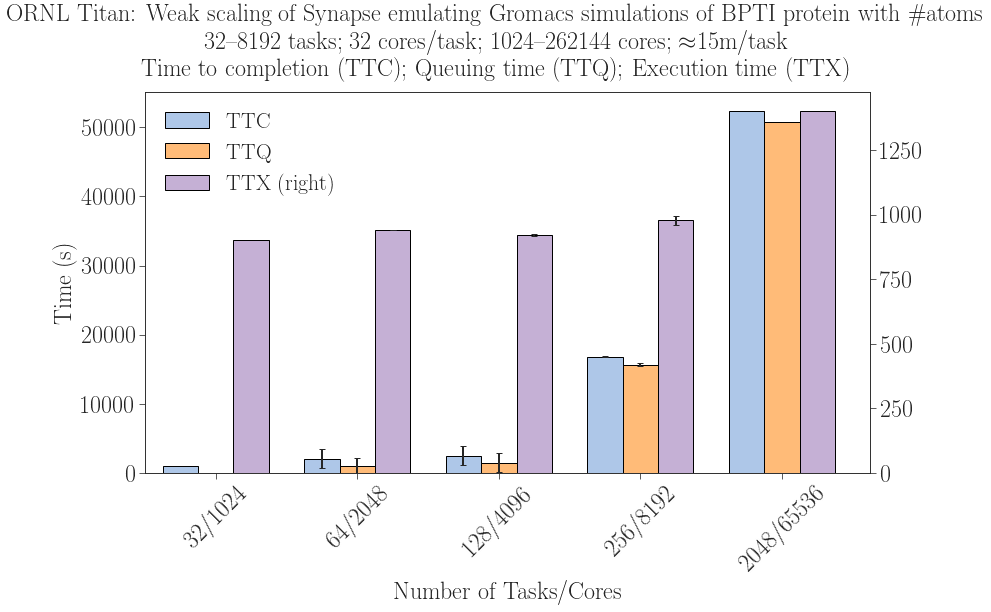

In [5]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

title_head = 'ORNL Titan: Weak scaling of Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '32--8192 tasks; 32 cores/task; 1024--262144 cores; $\\approx$15m/task' 
title_desc = 'Time to completion (TTC); Queuing time (TTQ); Execution time (TTX)'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

# Plot means and std bars
sws_scaling['TTC'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std',
    position=1.5, width=0.25, color=tableau20[1], ax=ax, rot=45,
    label='TTC')

sws_scaling['TTQ'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std',
    position=0.5, width=0.25, color=tableau20[3], ax=ax, rot=45,
    label='TTQ')

sws_scaling['TTX'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std', 
    position=-0.5, width=0.25, color=tableau20[9], ax=ax, rot=45, secondary_y=True,
    label='TTX')

ax.set_xlabel('Number of Tasks/Cores')
ax.set_ylabel('Time (s)')
ax.set_ylim(0)
ax.set_xlim(-0.5)

plt.savefig('figures/titan_rp_weak_scaling.pdf', dpi=600, bbox_inches='tight')

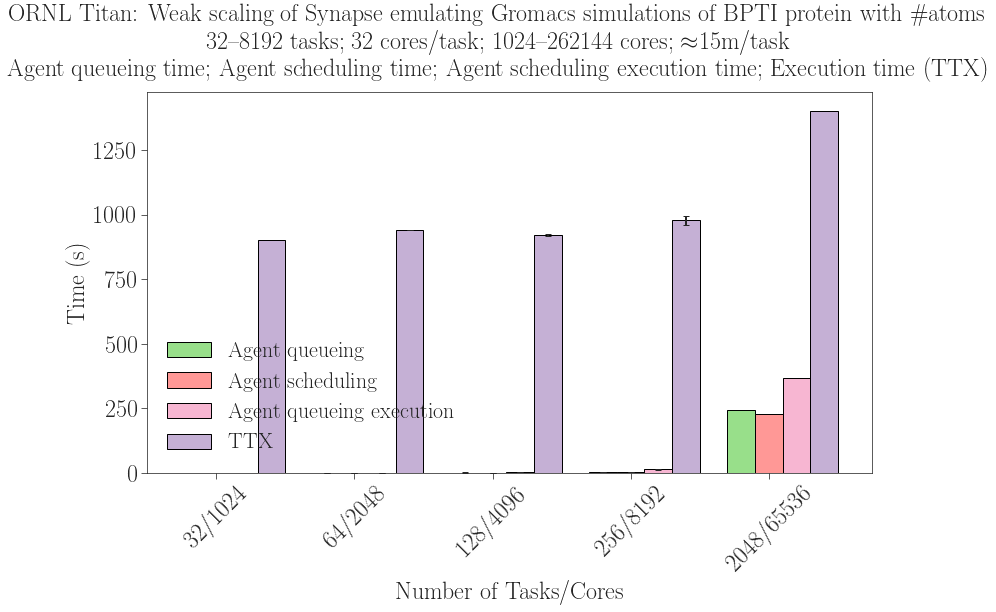

In [ ]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

title_head = 'ORNL Titan: Weak scaling of Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_work = '32--8192 tasks; 32 cores/task; 1024--262144 cores; $\\approx$15m/task' 
title_desc = 'Agent queueing time; Agent scheduling time; Agent scheduling execution time; Execution time (TTX)'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

# Plot means and std bars
sws_scaling['Agent queueing'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std',
    position=1.5, width=0.20, color=tableau20[5], ax=ax, rot=45,
    label='Agent queueing')

sws_scaling['Agent scheduling'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std',
    position=0.5, width=0.20, color=tableau20[7], ax=ax, rot=45,
    label='Agent scheduling')

sws_scaling['Agent queueing execution'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std',
    position=-0.5, width=0.20, color=tableau20[13], ax=ax, rot=45,
    label='Agent queueing execution')

sws_scaling['TTX'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std', 
    position=-1.5, width=0.20, color=tableau20[9], ax=ax, rot=45,
    label='TTX')

ax.set_xlabel('Number of Tasks/Cores')
ax.set_ylabel('Time (s)')
ax.set_ylim(0)
ax.set_xlim(-0.5)

plt.savefig('figures/titan_agent_weak_scaling.pdf', dpi=600, bbox_inches='tight')

# Analysis: Why we do not scale at 2048/32 tasks/cores

In [ ]:
# Load sessions for Synapse experiment 1
sras = load_sessions('/Users/mturilli/Projects/RADICAL/github/experiments/rp-paper-ipdps2018/analysis/data/synapse/weak_scaling', 
                     sws_sessions, 
                     sorted(sws_sessions.nunit.unique().tolist()))

In [ ]:
# Common variables across plotting 
sessions = sws_sessions
units    = sws_units
session  = sras[2048][0]
sid      = session._sid
snunit   = sws_sessions.loc[session._sid].nunit
sncore   = sws_sessions.loc[session._sid].ncore
muetime  = (units.AGENT_STAGING_OUTPUT_PENDING - units.AGENT_EXECUTING).mean()

# Set common title components
title_head = 'ORNL Titan: Analysis of Weak Scalability'
title_exec = '\\textbf{Executable}: Synapse emulating Gromacs simulations of BPTI protein with \#atoms'
title_conf = '\\textbf{Configuration}: 1 Executor; Orte; OpenMPI commit \#'
title_work = '\\textbf{Workload}: %s: \\textbf{%s tasks}; ?? cores/task; %s cores; $\\approx$??s/task' % (sid, snunit, sncore)#, muetime)

# Get events and order them by Scheduling
df = get_df_unit_events(session)
df = df.sort_values(by='Scheduler Stops Schedule')
df = df.reset_index(drop=True)

In [ ]:
fig, ax = fig_setup()

title = '%s\n%s\n%s\n%s\n%s' % (title_head, title_exec, title_conf, title_work, title_desc)
fig.suptitle(title, x=0.05, y=1.3, horizontalalignment='left')

# How many units are being scheduled
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'schedule_try'},               # Scheduling start
 {ru.STATE: None, ru.EVENT: 'schedule_ok'}])               # Scheduling stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[6])

# How many units are being queued for execution
scu = session.concurrency(event=[
 {ru.STATE: 'AGENT_EXECUTING_PENDING', ru.EVENT: 'state'}, # Queuing Execution start
 {ru.STATE: 'AGENT_EXECUTING', ru.EVENT: 'state'}])        # Queuing Execution stop  
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[4])

# How many units are being prepared for execution
scu = session.concurrency(event=[
 {ru.STATE: 'AGENT_EXECUTING', ru.EVENT: 'state'},         # Preparing Execution start
 {ru.STATE: None, ru.EVENT: 'exec_stop'}])                 # Preparing Execution stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[12])

# How many units are being executed
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'app_start'},                   # Execution start
 {ru.STATE: None, ru.EVENT: 'app_stop'}]   )                # Executed
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[0])

# How many units are being unscheduled
scu = session.concurrency(event=[
 {ru.STATE: None, ru.EVENT: 'unschedule_start'},            # Unscheduling start
 {ru.STATE: None, ru.EVENT: 'unschedule_stop'}])            # Unscheduling stop
x = [item[0] for item in scu]
y = [item[1] for item in scu]
ax.plot(x, y) #, color=tableau20[8])

ax.legend(ncol=3, loc='upper left', bbox_to_anchor=(0,1.25),
          labels=['Scheduling', 'Queuing Executor', 'Preparing Execute', 
                  # 'Checking Directory', 'Spawning', 
                  'Executing', 'Unscheduling'])
plt.xlabel('Time (s)')
plt.ylabel('Number of Units')

In [ ]:
fig, ax  = fig_hdouble_setup()

title_desc = '\\textbf{Measures}: Timestamps of \\textbf{units}'
title = '%s\n%s\n%s\n%s\n%s' % (title_head, title_exec, title_conf, title_work, title_desc)
fig.suptitle(title, x=0.1, y=1.4, horizontalalignment='left')

plt.scatter(df['Scheduler Starts Schedule'].index  , df['Scheduler Starts Schedule']  , marker='.') # Agent Scheduling Component
plt.scatter(df['Scheduler Stops Schedule'].index   , df['Scheduler Stops Schedule']   , marker='.') # Agent Scheduling Component
plt.scatter(df['Scheduler Queues CU'].index        , df['Scheduler Queues CU']        , marker='.') # Agent Scheduling Component
plt.scatter(df['Executor Starts'].index            , df['Executor Starts']            , marker='.') # Agent Executing Component
plt.scatter(df['Executor Starts Mkdir'].index      , df['Executor Starts Mkdir']      , marker='.') # Agent Executing Component
plt.scatter(df['Executor Stops Mkdir'].index       , df['Executor Stops Mkdir']       , marker='.') # Agent Executing Component
plt.scatter(df['Executor Spawns CU'].index         , df['Executor Spawns CU']         , marker='.') # Agent Executing Component
plt.scatter(df['OS Accepts Spawned CU'].index      , df['OS Accepts Spawned CU']      , marker='.') # System OS
plt.scatter(df['OS Spawns CU'].index               , df['OS Spawns CU']               , marker='.') # System OS
plt.scatter(df['CU Changes Dir'].index             , df['CU Changes Dir']             , marker='.') # CU script
plt.scatter(df['CU Starts Pre-execute'].index      , df['CU Starts Pre-execute']      , marker='.') # CU script
plt.scatter(df['CU Stops Pre-execute'].index       , df['CU Stops Pre-execute']       , marker='.') # CU script
plt.scatter(df['CU Spawns Executable'].index       , df['CU Spawns Executable']       , marker='.') # CU script [orterun spawner]
plt.scatter(df['Executable Starts'].index          , df['Executable Starts']          , marker='.') # Synapse
plt.scatter(df['Executable Stops'].index           , df['Executable Stops']           , marker='.') # Synapse, orterun [orterun spawner]
plt.scatter(df['CU Spawn Returns'].index           , df['CU Spawn Returns']           , marker='.') # CU script
plt.scatter(df['CU Starts Post-execute'].index     , df['CU Starts Post-execute']     , marker='.') # CU script
plt.scatter(df['CU Stops Post-executed'].index     , df['CU Stops Post-executed']     , marker='.') # CU script
plt.scatter(df['Executor Stops'].index             , df['Executor Stops']             , marker='.') # Agent Executing Component
plt.scatter(df['Scheduler Starts Unschedule'].index, df['Scheduler Starts Unschedule'], marker='.') # Agent Scheduling Component
plt.scatter(df['Scheduler Stops Unschedule'].index , df['Scheduler Stops Unschedule'] , marker='.') # Agent Scheduling Component


plt.legend(ncol=5, loc='upper left', bbox_to_anchor=(0,1.35))
plt.xlabel('Number of Units')
plt.ylabel('Time (s)')

#plt.savefig('figures/titan_synapse_strong_scaling_unit_events_16_full.pdf', dpi=300, bbox_inches='tight')